# PV Plots

Processing of PV fields is done in ../src/processPV.py and saved to ../data/interim/

There are several different processed fields there, including:
- Full Depth, from +-400 eta_rho (pvintegrated_fulldepth_b/noflux.nc)
- Index 50, from +-400 eta_rho (pvintegrated_b/noflux.nc)
- 500 m depth, from +-400 eta_rho (pvintegrated_500depth_b/noflux.nc)
- **TO DO** ??? depth, frontal zone (pvintegrated_???depth_fz_b/noflux.nc)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from dask.distributed import Client
import dask
import xarray as xr
import xgcm
from dask.diagnostics import ProgressBar
import sys
import matplotlib.patches as patches
sys.path.append('/homes/metofac/wenegrat/xroms/')
#sys.path.append('/homes/metofac/wenegrat/pyspec/')

#from xroms import open_roms_netcdf_dataset
import cmocean.cm as cmo
import xroms
#from pyspec import spectrum as spec
from scipy import integrate as integrate
from timeit import default_timer as timer

#%%
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 14
plt.rcParams['contour.negative_linestyle'] = 'solid'

import sys
sys.path.append("../src/")
import load_model_runs as lruns

from importlib import reload  
import time

/homes/metofac/wenegrat/xroms/xroms/interp.py:18: UserWarning: xESMF is not installed, so `interpll` will not run.
  warnings.warn("xESMF is not installed, so `interpll` will not run.")


In [4]:
## LOAD THE RUNS and THE PV FIELD
#################################
# Note that need to be careful here about getting consistent datasets (ie. all bflux etc)

# Load the raw datasets
reload(lruns)
dsWC, gridWC = lruns.newLoad('../data/model/JET_NML_CFB/', chunks={'time':1})
dsNC, gridNC = lruns.newLoad('../data/model/JET_NML_NOCFB/', chunks={'time':1})

# Load the PV fields
dsPV = xr.open_dataset('../data/interim/pvintegrated_noflux.nc', engine='netcdf4')
yl = slice(400, 4002-400)
zl = slice(50, 100)

In [ ]:
# Calculate EBF fields
bx = xroms.to_rho(-9.8/1020*gridWC.derivative(dsWC.rho.isel(s_rho=-1), 'X'), gridWC)
by = xroms.to_rho(-9.8/1020*gridWC.derivative(dsWC.rho.isel(s_rho=-1), 'Y'), gridWC)
dsWC['bx'] = bx
dsWC['by'] = by
dsWC['EBF'] = ((bx*xroms.to_rho(dsWC.svstr, gridWC) - by*xroms.to_rho(dsWC.sustr, gridWC))/(dsWC.f*1020)).compute()
dsWC['EBFm'] = (bx*1e-3*7*5 - by*1e-3*7*5)/(dsWC.f*1020)
dsWC['Nablab'] = np.sqrt(bx**2 + by**2)

bx = xroms.to_rho(-9.8/1020*gridNC.derivative(dsNC.rho.isel(s_rho=-1), 'X'), gridNC)
by = xroms.to_rho(-9.8/1020*gridNC.derivative(dsNC.rho.isel(s_rho=-1), 'Y'), gridNC)
dsNC['bx'] = bx
dsNC['by'] = by
dsNC['EBF'] = ((bx*xroms.to_rho(dsNC.svstr, gridNC) - by*xroms.to_rho(dsNC.sustr, gridNC))/(dsNC.f*1020)).compute()
dsNC['Nablab'] = np.sqrt(bx**2 + by**2)

In [19]:
dsWC.z_rho0.mean(('eta_rho', 'xi_rho'))[50].values

array(-359.5309, dtype=float32)

## PLOT

NameError: name 'dsPV' is not defined

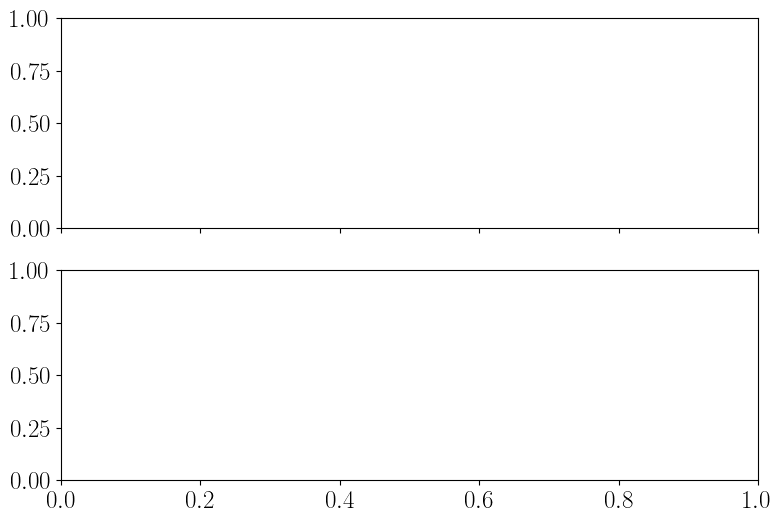

In [3]:
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 18
plt.rcParams['contour.negative_linestyle'] = 'solid'

fig, ax = plt.subplots(2,1, figsize=(9,6), sharex=True)
startdate = 5
normPV = 200*1002*3000 # XXX THIS SHOULD BE INTEGRATED VOLUME (DEPENDS ON PARAMETERS)
ax[1].plot(dsPV.time[startdate:]/86400, (dsPV.pv_wc[startdate:]-dsPV.pv_wc[startdate])/normPV, linewidth=2, label='CFB')
ax[1].plot(dsPV.time[startdate:]/86400, (dsPV.pv_nc[startdate:]-dsPV.pv_nc[startdate])/normPV, label='NO CFB', linestyle='--', linewidth=2)
ax[1].grid()
ax[1].set_ylabel('Change in mean PV\n [s$^{-3}$]', labelpad=12)
#ax[1].set_ylim(-1e-11, 0.9e-10)
btowatts=(1020*4000)/(2e-4*9.8)

ax[0].plot(dsWC.time[startdate:]/86400, btowatts*dsWC.EBF.isel(eta_rho=yl).mean(('eta_rho', 'xi_rho'))[startdate:], linewidth=2, label='CFB')
ax[0].plot(dsNC.time[startdate:]/86400, btowatts*dsNC.EBF.isel(eta_rho=yl).mean(('eta_rho', 'xi_rho'))[startdate:], label='NO CFB', linestyle='--', linewidth=2)
ax[0].grid()
ax[0].set_ylabel('Ekman heat flux\n [W m$^{-2}$]')
ax[0].set_ylim(0, 15)
ax[1].legend(bbox_to_anchor=(0.85, 1.35), ncol=1, framealpha=1)

ax[1].set_xlim(365, 390)
ax[1].set_xlabel('Days')

print(f'PV ratio:{(dsPV.pv_wc[-1]-dsPV.pv_wc[startdate])/(dsPV.pv_nc[-1]-dsPV.pv_nc[startdate])} ')
#plt.savefig(f'../figures/DeltaPV_{runname}.pdf', bbox_inches='tight')

# Questions

What are the questions I need to answer with this plot (to determine which analysis to use).

- How much does depth of integration matter (full, 500 m, index 50)?
- What does it look like to do this for only the frontal zone? Presumably this looks very different for the bflux simulation where the surface buoyancy driven PV fluxes happen everywhere, whereas the frontal component only in the middle of the domain.

### OLD STUFF

In [2]:
client = Client(processes=False)
client

/homes/metofac/wenegrat/.conda/envs/CFB_EBF_3/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34897 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://128.8.216.13:34897/status,
Dashboard: http://128.8.216.13:34897/status,Workers: 1
Total threads: 128,Total memory: 503.40 GiB
Status: running,Using processes: False
Comm: inproc://128.8.216.13/122440/1,Workers: 1
Dashboard: http://128.8.216.13:34897/status,Total threads: 128
Started: Just now,Total memory: 503.40 GiB
Comm: inproc://128.8.216.13/122440/4,Total threads: 128
Dashboard: http://128.8.216.13:44520/status,Memory: 503.40 GiB
Nanny: None,


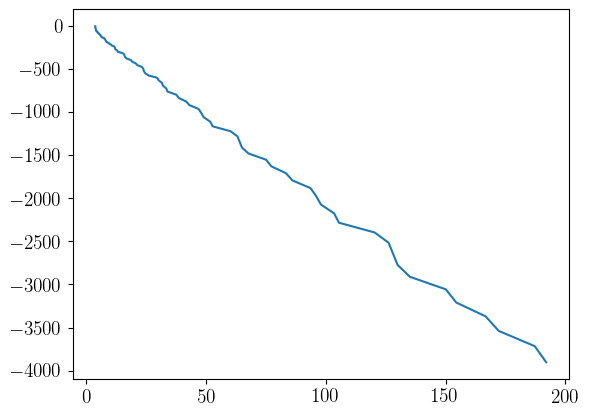

In [42]:
plt.plot(dsWC.dz0.mean(('eta_rho', 'xi_rho')), dsWC.z_rho0.mean(('eta_rho', 'xi_rho')))

In [44]:
ind = np.argmin(np.abs(dsWC.z_rho0.mean(('eta_rho', 'xi_rho')).values + 500))
ind

43

In [17]:
# def calcIntegratedPV(dst, ts, yl, zl=slice(50,100)):
#     dst = dst.swap_dims({'ocean_time':'time'})
#     dst['buoyancy'] = xroms.buoyancy(dst.rho, rho0=dst.rho0)
#     t = time.time()
#     PV = dst.xroms.ertel.isel(time=ts)
#     PV_areaweigh = PV*dst.dz0*dst.dA 
#     PV_sum = PV_areaweigh.isel(eta_rho=yl, s_rho=zl).sum().compute()
#     return PV_sum

def calcIntegratedPV(dst, ts, yl, zl=slice(50,100)):
    dst = dst.swap_dims({'ocean_time':'time'})
    dst['buoyancy'] = xroms.buoyancy(dst.rho, rho0=dst.rho0)
    t = time.time()
    PV = dst.isel(time=ts).xroms.ertel
    PV_areaweigh = PV*dst.dz0*dst.dA 
    PV_sum = PV_areaweigh.isel(eta_rho=yl, s_rho=zl).sum().compute()
    return PV_sum

In [18]:
yl = slice(400, 4002-400)
nt = 41
print('Processing WC')
PV_WC = np.zeros((nt,))
for i in range(0,nt):
    tic = time.perf_counter()
    PV_WC[i] = calcIntegratedPV(dsWC, i, yl)
    toc = time.perf_counter()
    print(f'Processing step {i}/{nt} took: {(toc-tic)/60} min', end="\r") # Should take approximately 1.2 min/step

print('Processing NC')
PV_NC = np.zeros((nt,))
for i in range(0,nt):
    tic = time.perf_counter()
    PV_NC[i] = calcIntegratedPV(dsNC, i, yl)
    toc = time.perf_counter()
    print(f'Processing step {i}/{nt} took: {(toc-tic)/60} min', end="\r") # Should take approximately 1.2 min/step
    
#save to interim     
dspv = xr.Dataset(
        data_vars = dict(
        pv_wc=(['time'], PV_WC),
        pv_nc=(['time'], PV_NC),    
        ),
        coords = dict(
        time=dsWC.time.values[0:nt]
        )
)
dspv.attrs['type'] = 'noflux'
dspv.attrs['yl_l'] = yl.start
dspv.attrs['yl_r'] = yl.stop
#dspv.attrs['zl_l'] = zl.start
dspv.to_netcdf('../data/interim/pvintegrated_noflux.nc')    

Processing WC


KeyboardInterrupt: 

In [8]:
# Save to interim 
dspv


NameError: name 'dspv' is not defined

In [9]:
plt.plot(dspv.time, dspv.pv_wc)
plt.plot(dspv.time, dspv.pv_nc)

NameError: name 'dspv' is not defined

In [ ]:
sd = 5
plt.plot(PV_WC[0:30]-PV_WC[sd])
plt.plot(PV_NC[0:30]-PV_NC[sd])
plt.plot(pvfluxi[0:30] - pvfluxi[sd])
#plt.plot(pvfluxi_nc[0:30] - pvfluxi_nc[sd])

print((PV_WC[30]-PV_WC[sd])/(PV_NC[30]-PV_NC[sd]))


In [ ]:
surft = 25*2e-4/3994
hbl = dsWC.hbl+1
hflx = ((surft/(hbl))*dsWC.f*dsWC.dA).isel(eta_rho=yl).sum(('eta_rho', 'xi_rho')).compute()
pvflux = -9.8*hflx/1020
pvfluxi = integrate.cumtrapz(pvflux, x=dsWC.ocean_time, initial=0)

hbl = dsNC.hbl+1
hflx = ((surft/(hbl))*dsNC.f*dsNC.dA).isel(eta_rho=yl).sum(('eta_rho', 'xi_rho')).compute()
pvflux = -9.8*hflx/1020
pvfluxi_nc = integrate.cumtrapz(pvflux, x=dsWC.ocean_time, initial=0)

In [ ]:
sd = 5
fpv_wc = PV_WC[0:31] - pvfluxi[0:31]
fpv_nc = PV_NC[0:31] - pvfluxi_nc[0:31]

plt.plot(fpv_wc - fpv_wc[sd])
plt.plot(fpv_nc - fpv_nc[sd])
print((fpv_wc[30]-fpv_nc[sd])/(fpv_nc[30]-fpv_nc[sd]))


## Make the figure! (finally)

In [ ]:
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 18
plt.rcParams['contour.negative_linestyle'] = 'solid'

fig, ax = plt.subplots(2,1, figsize=(9,6), sharex=True)
startdate = 5
normPV = 200*1002*3000
ax[1].plot(dstemp.time[startdate:len(VIPV_CFB)]/86400, (VIPV_CFB[startdate:]-VIPV_CFB[startdate])/normPV, linewidth=2, label='CFB')
ax[1].plot(dstemp.time[startdate:len(VIPV_NOCFB)]/86400, (VIPV_NOCFB[startdate:]-VIPV_NOCFB[startdate])/normPV, label='NO CFB', linestyle='--', linewidth=2)
ax[1].grid()
ax[1].set_ylabel('Change in mean PV\n [s$^{-3}$]', labelpad=12)
#ax[1].set_ylim(-1e-11, 0.9e-10)
btowatts=(1020*4000)/(2e-4*9.8)

ax[0].plot(dsWC.time[startdate:]/86400, btowatts*dsWC.EBF.isel(eta_rho=slice(1500, 2500)).mean(('eta_rho', 'xi_rho'))[startdate:], linewidth=2, label='CFB')
ax[0].plot(dsNC.time[startdate:]/86400, btowatts*dsNC.EBF.isel(eta_rho=slice(1500, 2500)).mean(('eta_rho', 'xi_rho'))[startdate:], label='NO CFB', linestyle='--', linewidth=2)
ax[0].grid()
ax[0].set_ylabel('Ekman heat flux\n [W m$^{-2}$]')
ax[0].set_ylim(0, 15)
ax[1].legend(bbox_to_anchor=(0.85, 1.35), ncol=1, framealpha=1)

ax[1].set_xlim(365, 390)
ax[1].set_xlabel('Days')

print(f'PV ratio:{(VIPV_CFB[-1]-VIPV_CFB[startdate])/(VIPV_NOCFB[-1]-VIPV_NOCFB[startdate])} ')
#plt.savefig(f'../figures/DeltaPV_{runname}.pdf', bbox_inches='tight')

## Process iteratively

In [ ]:
destination = '../data/interim/'+runname+'/'

dst = dsWC
dst = dst.swap_dims({'ocean_time':'time'})
dst['buoyancy'] = xroms.buoyancy(dst.rho, rho0=dst.rho0)
nt = dst.ocean_time.size
for i in range(0, nt):
    tic = time.perf_counter()
    PV = dst.isel(time=i).xroms.ertel.compute()
    PVDS = PV.to_dataset()
    for variable in PVDS.variables.values():
            try:
                variable.attrs.pop('grid')
            except:
                dummy = []
    PVDS.to_netcdf(destination +f'pv_{i}.nc')
    toc = time.perf_counter()
    print(f'Processing step {i}/{nt} took: {(toc-tic)/60} min')

In [ ]:
dst.xroms.ertel.isel(s_rho=slice(50,100))

In [15]:
dsWC['buoyancy'] = xroms.buoyancy(dsWC.rho, 1020)
dsWC
PV = dsWC.xroms.ertel.isel(time=ts)

AttributeError: 'Dataset' object has no attribute 'salt'

In [13]:
dspv = xr.open_dataset('../data/interim/pvintegrated_noflux.nc', engine='netcdf4')
dspv

<xarray.Dataset>
Dimensions:  (time: 31)
Coordinates:
  * time     (time) float64 3.11e+07 3.119e+07 3.128e+07 ... 3.361e+07 3.37e+07
Data variables:
    pv_wc    (time) float64 ...
    pv_nc    (time) float64 ...
Attributes:
    type:     noflux
    yl_l:     400
    yl_r:     3602

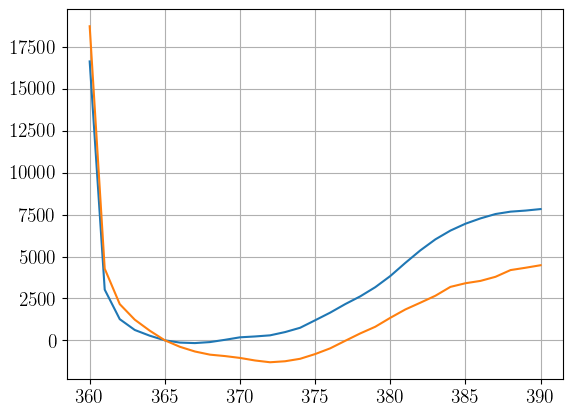

In [28]:
plt.plot(dspv.time/86400, dspv.pv_wc-dspv.pv_wc[fts])
plt.plot(dspv.time/86400, dspv.pv_nc-dspv.pv_nc[fts])
plt.grid()

In [27]:
fts = 5
del_pv_perc = (dspv.pv_wc[-1]-dspv.pv_wc[fts])/(dspv.pv_nc[-1]-dspv.pv_nc[fts])

print(f'Ratio of WC/NC PV at final step: {del_pv_perc.values}')

Ratio of WC/NC PV at final step: 1.7477723471971987


In [9]:
a = np.linspace(0, 50, 100)

In [10]:
a

array([ 0.        ,  0.50505051,  1.01010101,  1.51515152,  2.02020202,
        2.52525253,  3.03030303,  3.53535354,  4.04040404,  4.54545455,
        5.05050505,  5.55555556,  6.06060606,  6.56565657,  7.07070707,
        7.57575758,  8.08080808,  8.58585859,  9.09090909,  9.5959596 ,
       10.1010101 , 10.60606061, 11.11111111, 11.61616162, 12.12121212,
       12.62626263, 13.13131313, 13.63636364, 14.14141414, 14.64646465,
       15.15151515, 15.65656566, 16.16161616, 16.66666667, 17.17171717,
       17.67676768, 18.18181818, 18.68686869, 19.19191919, 19.6969697 ,
       20.2020202 , 20.70707071, 21.21212121, 21.71717172, 22.22222222,
       22.72727273, 23.23232323, 23.73737374, 24.24242424, 24.74747475,
       25.25252525, 25.75757576, 26.26262626, 26.76767677, 27.27272727,
       27.77777778, 28.28282828, 28.78787879, 29.29292929, 29.7979798 ,
       30.3030303 , 30.80808081, 31.31313131, 31.81818182, 32.32323232,
       32.82828283, 33.33333333, 33.83838384, 34.34343434, 34.84